In [1]:
import glob
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from shapely import buffer
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np

def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def chip(img, envelope_gdf):
    with rasterio.open(img) as src:
        # Crop the image based on the envelope around the polygon
        window = src.window(*envelope_gdf.total_bounds)
        r, g, b = (normalize(src.read(k,window=window)) for k in (4, 3, 2))
    return np.dstack((r, g, b))

def find_method(fn):
    sensor = fn.split('_')[1]
    if sensor == 's1s2':
        if fn.split('_')[2] == 'append':
            return 'Appended'
        else:
            return 'Merged'
    else:
        sensor = sensor.replace('s1', 'SAR')
        sensor = sensor.replace('s2', 'EO')
        return sensor

In [2]:
image_paths = [
    # "/filserver/user/imagery/Sentinel-2/2020/S2A_MSIL2A_20200626T104031_N0500_R008_T32VNM_20230507T041856_aligned_12b.tiff",
    "/filserver/user/imagery/Sentinel-2/2021/S2A_MSIL2A_20210624T105031_N0500_R051_T32VNM_20230318T092732_aligned_12b.tiff",
    # "/filserver/user/imagery/Sentinel-2/2022/S2B_MSIL2A_20220813T104629_N0400_R051_T32VNM_20220813T122218_aligned_12b.tiff",
    "/filserver/user/imagery/Sentinel-2/2023/S2A_MSIL2A_20230624T104621_N0509_R051_T32VNM_20230624T170454_aligned_12b.tiff"
               ]

,DN,name,order,lat_lng,geometry
0,1,highway,1,601756N 0103633E,"MULTIPOLYGON (((588525.885 6686542.045, 588644..."
1,1,small road,2,600547N 0102311E,"MULTIPOLYGON (((577366.778 6663426.010, 577384..."
2,1,residential area,3,601327N 0102129E,"MULTIPOLYGON (((575171.771 6677367.332, 575194..."
3,1,mountain hut area,4,602105N 0092840E,"MULTIPOLYGON (((526516.010 6690517.207, 526511..."
4,1,detached houses,5,601510N 0095605E,"MULTIPOLYGON (((551741.871 6679900.708, 551728..."
5,1,public indoor pool,6,595509N 0104644E,"MULTIPOLYGON (((599423.541 6643661.197, 599427..."
6,1,industrial area,7,601442N 0095706E,"MULTIPOLYGON (((552497.236 6679264.773, 552498..."


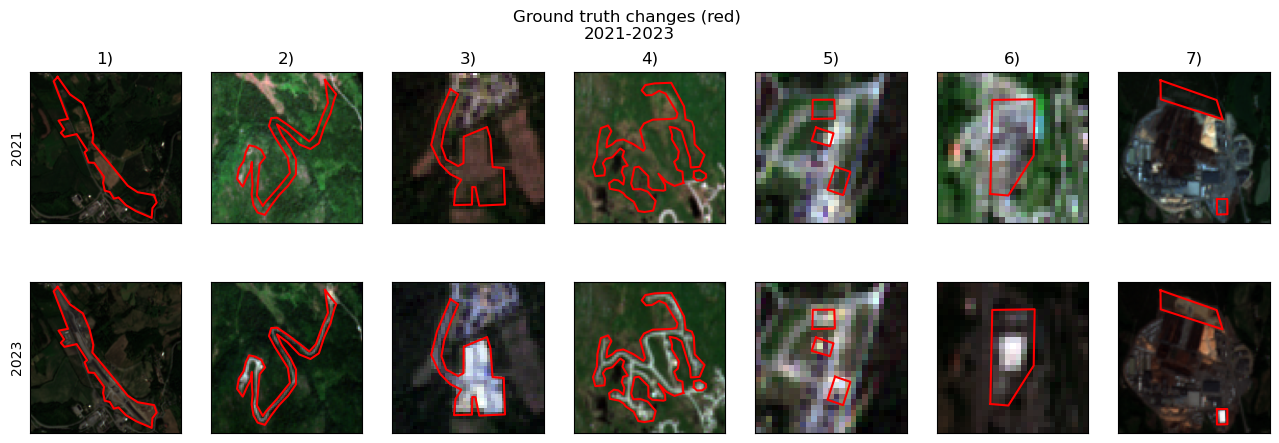

In [13]:
buffer_m = 50
search_distance = buffer_m

years = [
        #  '2021_2022',
        #  '2022_2023',
         '2021_2023'
         ]

for y, year in enumerate(years):
    imgs_pairs = image_paths[y:y+2]
    change_geojson = f"./results/difference_man_{year}.geojson"
    # display(change_geojson)
    gdf = gpd.read_file(change_geojson).sort_values(by='order').reset_index(drop=True)
    display(gdf)
    
    fig, ax = plt.subplots(ncols=len(gdf), nrows=2, figsize=(16,5))
    fig.suptitle(f"Ground truth changes (red) \n{year.replace('_', '-')}")

    ax[0,0].set_ylabel(year.split("_")[0])
    ax[1,0].set_ylabel(year.split("_")[1])
    
    for n in range(len(gdf)):
        geoms = gdf.geometry.iloc[n]
        if geoms.geom_type == 'MultiPolygon':
            polygon_l = list(gdf.geometry.iloc[n].geoms)
        else:
            polygon_l = list(gdf.geometry.iloc[n])

        bounds = list(geoms.bounds)
        ds = [bounds[2]-bounds[0], bounds[3]-bounds[1]]
        min_d, max_d = min(ds), max(ds)
        index_min = min(range(len(ds)), key=ds.__getitem__)
        dif = max_d/2 - min_d/2
        square_bound = bounds
        square_bound[index_min::2] = [square_bound[index_min]-dif, square_bound[2+index_min]+dif]

        buffer_box = list(map(sum, zip(square_bound, (-buffer_m, -buffer_m, buffer_m, buffer_m))))
        bbox_geometry = gpd.GeoSeries([box(*buffer_box)])
        envelope_gdf = gpd.GeoDataFrame(geometry=bbox_geometry)

        img1 = chip(imgs_pairs[0], envelope_gdf).transpose(2,0,1)
        show(img1, ax=ax[0,n], extent=(buffer_box[0],buffer_box[2],buffer_box[1],buffer_box[3]))
        img2 = chip(imgs_pairs[1], envelope_gdf).transpose(2,0,1)
        show(img2, ax=ax[1,n], extent=(buffer_box[0],buffer_box[2],buffer_box[1],buffer_box[3]))

        for p in polygon_l:
            x_l,y_l = p.exterior.xy
            ax[0,n].plot(x_l,y_l, color='red')
            ax[1,n].plot(x_l,y_l, color='red')
        
        ax[0,n].set_title(f"{n+1})")
        
        ax[0, n].set_xticks([])
        ax[0, n].set_yticks([])
        ax[1, n].set_xticks([])
        ax[1, n].set_yticks([])

    plt.show()

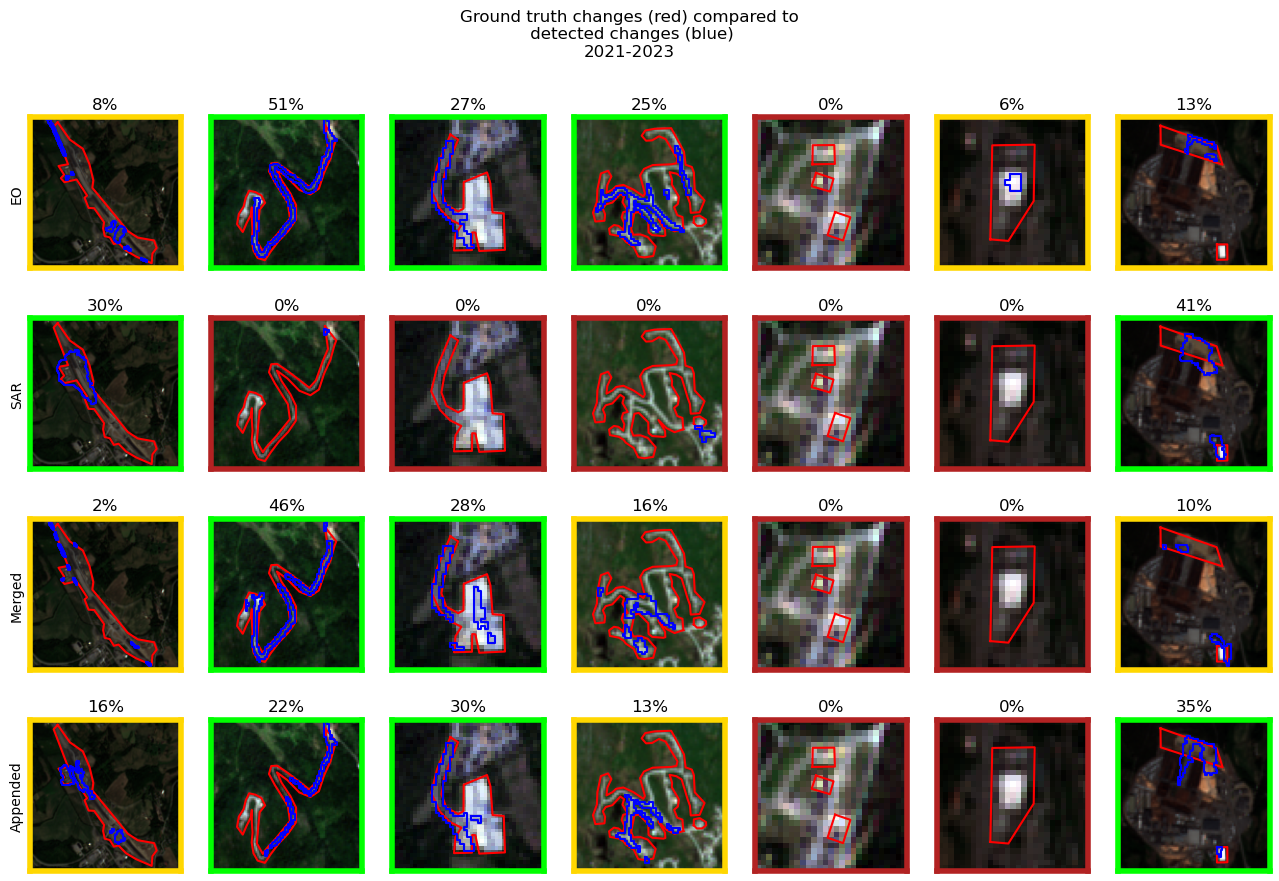

In [16]:
buffer_m = 50
search_distance = 200

years = [
        #  '2021_2022',
        #  '2022_2023',
         '2021_2023'
         ]

for y, year in enumerate(years):
    imgs_pairs = image_paths[y:y+2]
    /home/local/NTU/frrov/multi-modal-cd_scripts/geodata/difference_man_2021_2023.geojson
    change_geojson = f"./geodata/difference_man_{year}.geojson"
    # display(change_geojson)
    gdf = gpd.read_file(change_geojson).sort_values(by='order').reset_index(drop=True)
    # display(gdf)
    
    match_geojsons = glob.glob(f"./results/difference_[!man]*_{year}_norm.geojson")[::-1]
    
    fig, ax = plt.subplots(ncols=len(gdf), nrows=len(match_geojsons), figsize=(16,10))
    fig.suptitle(f"Ground truth changes (red) compared to\n detected changes (blue)\n{year.replace('_', '-')}")
    
    for i, match_geojson in enumerate(match_geojsons):
        match_gdf = gpd.read_file(match_geojson)
        method = find_method(match_geojson)
        # display(match_gdf)
        matched_gdf = gdf.sjoin_nearest(match_gdf, distance_col='distance', max_distance=search_distance)
        matched_gdf = pd.merge(matched_gdf, match_gdf, left_on='index_right', right_index=True, suffixes=['_left', '_right']).sort_values(by='mean_left', ascending=False)
        # display(matched_gdf)



        ax[i,0].set_ylabel(method)
        
        for n in range(len(gdf)):
            geoms = gdf.geometry.iloc[n]
            if geoms.geom_type == 'MultiPolygon':
                polygon_l = list(gdf.geometry.iloc[n].geoms)
                area_l = 0
                for g in polygon_l:
                    area_l += g.area
            else:
                polygon_l = list(gdf.geometry.iloc[n])
                area_l = polygon_l[0].area
            # print(polygon_l)
            # x_l,y_l = polygon_l.exterior.xy
            
            polygon_r = gpd.GeoSeries(matched_gdf['geometry_right'].get(n,None))

            # area_r = 0
            # for g in polygon_r:
            #     area_r += g.area
            # print(area_r)

            area_r = 0
            for index, orig in enumerate(polygon_l):
                for index2, ref in enumerate(polygon_r):
                    if ref.intersects(orig):
                        area_r += ref.buffer(0).intersection(orig).area
            # print(area_r)
            
            prc_cov = round(area_r/area_l*100)
            # print(prc_cov, '%')

            bounds = list(geoms.bounds)
            ds = [bounds[2]-bounds[0], bounds[3]-bounds[1]]
            min_d, max_d = min(ds), max(ds)
            index_min = min(range(len(ds)), key=ds.__getitem__)
            dif = max_d/2 - min_d/2
            square_bound = bounds
            square_bound[index_min::2] = [square_bound[index_min]-dif, square_bound[2+index_min]+dif]

            buffer_box = list(map(sum, zip(square_bound, (-buffer_m, -buffer_m, buffer_m, buffer_m))))
            bbox_geometry = gpd.GeoSeries([box(*buffer_box)])
            envelope_gdf = gpd.GeoDataFrame(geometry=bbox_geometry)

            # img1 = chip(imgs_pairs[0], envelope_gdf).transpose(2,0,1)
            # show(img1, ax=ax[0,n], extent=(buffer_box[0],buffer_box[2],buffer_box[1],buffer_box[3]))
            img2 = chip(imgs_pairs[1], envelope_gdf).transpose(2,0,1)
            show(img2, ax=ax[i,n], extent=(buffer_box[0],buffer_box[2],buffer_box[1],buffer_box[3]))

            for p in polygon_l:
                x_l,y_l = p.exterior.xy
                ax[i,n].plot(x_l,y_l, color='red')
            if polygon_r.empty:
                ax[i,n].set_title(f"{prc_cov}%")
                pass
            else:
                ax[i,n].set_title(f"{prc_cov}%")
                for geom in polygon_r:
                    x_r,y_r = geom.exterior.xy
                    ax[i,n].plot(x_r,y_r, color='blue')
            
            if prc_cov < 1:
                edge_color = 'firebrick'
            elif prc_cov < 20:
                edge_color = 'gold'
            else:
                edge_color = 'lime'
            
            for spine in ax[i, n].spines.values():
                spine.set_edgecolor(edge_color)
                spine.set_linewidth(4)
            
            ax[i, n].set_xticks([])
            ax[i, n].set_yticks([])

    plt.show()